<h2>Imports and constants</h2>

In [106]:
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pycountry
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
%matplotlib inline

In [2]:
data_path = 'data/'
#data_path = 'C:\Users\Jakob\Desktop\RMIT\Practical Data Science\Assignment 2\\'

<h2>Functions</h2>

<h2>Merging world cities and cost of living index datasets</h2>

In [3]:
# Load world cities
new_cities = pd.read_csv(data_path + 'worldcitiespop.csv', sep=",")
# Take only first 2000 most populated cities and drop any duplicates in city names.
new_cities = new_cities.sort_values("Population", ascending=False)[0:2000].drop_duplicates("City")
new_cities["Country"] = new_cities["Country"].str.upper()
new_cities = new_cities[["City", "Country", "Population", "Latitude", "Longitude"]]

/home/filip/anaconda2/envs/geo/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Load cost of living index
coli = pd.read_csv(data_path + 'Cost_of_living_index.csv', sep=",")

In [5]:
# Parse original "City" column to "City" and "Country" columns
coli["City"], coli["Country"] = coli["City"].str.split(", ", 1).str
# Remove state from the USA Country.
coli["Country"] = coli["Country"].apply(lambda x: "United States" if "United States" in x else x)
coli["City"] = coli["City"].str.lower()
coli = coli[["City", "Country", "Cost of Living Plus Rent Index", "Local Purchasing Power Index"]]

In [6]:
# Transform country name to country code.
def name2code(country_name):
    rep = pycountry.countries.get(name=country_name)
    if rep is None:
        rep = pycountry.countries.get(official_name=country_name)
        if rep is None:
            return np.nan
        else:
            return rep.alpha_2
    else:
        return rep.alpha_2
coli["Country"] = coli["Country"].apply(lambda country_name: name2code(country_name))
coli.dropna(inplace=True)

In [7]:
# Check how many cities we have now.
new_cities.shape

(1969, 5)

In [8]:
# Merge new cities and cost of living index datasets.
#df = pd.merge(new_cities, coli, on="City", how="inner")
df = pd.merge(new_cities, coli, on=["City", "Country"], how="inner")
df.shape

(359, 7)

In [9]:
# Are there still any duplicates?
df.City.value_counts().sort_values(ascending=False)[df.City.value_counts().sort_values(ascending=False) > 1]

portland    2
Name: City, dtype: int64

In [10]:
# Just Portland, remove it.
df = df[df["City"] != "portland"]

In [11]:
df.head(10)

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index
0,tokyo,JP,31480498.0,35.685000,139.751389,61.89,113.09
1,shanghai,CN,14608512.0,31.045556,121.399722,42.68,72.16
2,karachi,PK,11627378.0,24.905600,67.082200,15.50,36.66
3,delhi,IN,10928270.0,28.666667,77.216667,19.23,77.75
4,manila,PH,10443877.0,14.604200,120.982200,27.46,40.04
5,sao paulo,BR,10021437.0,-23.473293,-46.665803,31.11,41.16
6,istanbul,TR,9797536.0,41.018611,28.964722,25.24,50.13
7,lagos,NG,8789133.0,6.453056,3.395833,31.86,19.41
8,jakarta,ID,8540306.0,-6.174444,106.829444,29.39,28.95
9,new york,US,8107916.0,40.714167,-74.006389,100.00,100.00


In [12]:
df.shape

(357, 7)

<h2>Temperature</h2>

In [13]:
temperature = pd.read_csv(data_path + 'temperatures.csv', sep=',', decimal='.')

In [14]:
temperature['dt'] = pd.to_datetime(temperature['dt'])

In [15]:
temperature.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object

In [16]:
# Take average temperature for year 2012 (newest).
temperature['year'] = temperature.dt.dt.year
new_temperatures = temperature[temperature.year == 2012][['City', "Country", 'AverageTemperature']].groupby(['City', "Country"], as_index=False).mean()
new_temperatures["City"] = new_temperatures["City"].str.lower()

In [17]:
# Transform Country to code.
new_temperatures["Country"] = new_temperatures["Country"].apply(lambda country_name: name2code(country_name))
new_temperatures.dropna(inplace=True)

In [18]:
# Print cities throwed away due to lack of ttemperature information.
tmp = pd.merge(df, new_temperatures, on="City", how='left')
tmp[tmp["AverageTemperature"].isna()]

,City,Country_x,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Country_y,AverageTemperature
5,sao paulo,BR,10021437.0,-23.473293,-46.665803,31.11,41.16,NaN,NaN
14,bogota,CO,7102602.0,4.649178,-74.062827,24.44,37.44,NaN,NaN
57,brasilia,BR,2207812.0,-15.783333,-47.916667,29.76,63.24,NaN,NaN
63,medellin,CO,2000001.0,6.251840,-75.563591,23.09,34.02,NaN,NaN
157,merida,MX,717196.0,20.966667,-89.616667,18.19,40.29,NaN,NaN
173,queretaro,MX,611803.0,20.600000,-100.383333,20.72,57.83,NaN,NaN
187,dusseldorf,DE,577139.0,51.216667,6.766667,53.99,115.58,NaN,NaN
193,malaga,ES,557875.0,36.726666,-4.434802,36.24,87.90,NaN,NaN
199,cancun,MX,542156.0,21.166667,-86.833333,21.39,53.68,NaN,NaN
209,asuncion,PY,508797.0,-25.266667,-57.666667,22.62,37.30,NaN,NaN


In [19]:
# No duplicates in cities
new_temperatures["City"].value_counts(ascending=False).head()

worcester    3
león         3
santiago     3
syracuse     2
cadiz        2
Name: City, dtype: int64

In [20]:
df = pd.merge(df, new_temperatures, on=["City", "Country"], how='inner')

In [21]:
# No duplicates in City.
df["City"].value_counts(ascending=False).head()

plovdiv           1
tampere           1
brussels          1
lyon              1
port elizabeth    1
Name: City, dtype: int64

In [22]:
df.shape

(338, 8)

<h2>Liveability</h2>

In [23]:
liveability = pd.read_csv(data_path + 'liveability.csv', sep=',')

In [24]:
liveability["City"] = liveability.City.str.lower()
liveability = liveability[["City", "Movehub Rating"]]
liveability.rename(columns={"Movehub Rating": "Liveability"}, inplace=True)

In [25]:
liveability.head()

,City,Liveability
0,caracas,65.18
1,johannesburg,84.08
2,fortaleza,80.17
3,saint louis,85.25
4,mexico city,75.07


In [26]:
df = pd.merge(df, liveability, on="City", how='inner')

In [27]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability
0,tokyo,JP,31480498.0,35.685000,139.751389,61.89,113.09,13.113250,80.00
1,shanghai,CN,14608512.0,31.045556,121.399722,42.68,72.16,16.474500,75.69
2,karachi,PK,11627378.0,24.905600,67.082200,15.50,36.66,26.749833,67.81
3,delhi,IN,10928270.0,28.666667,77.216667,19.23,77.75,25.889417,77.12
4,manila,PH,10443877.0,14.604200,120.982200,27.46,40.04,27.336417,68.31


In [28]:
df.shape

(160, 9)

<h2>Unemployment rate</h2>

In [29]:
unemployment = pd.read_csv(data_path + 'unemployment.csv', sep=',', decimal='.')

In [30]:
# All the indicators, we choose 3296 - Unemployment rate (% of total labor force) (WEO)
unemployment[["Indicator Id", "Indicator"]].drop_duplicates()

,Indicator Id,Indicator
0,346,Gross national savings (% of GDP)
1,347,"Inflation, average consumer prices"
2,352,Population (WEO)
3,354,General government total expenditure
4,355,General government net lending/borrowing
5,357,General government primary net lending/borrowing
6,359,General government gross debt
7,360,Gross domestic product corresponding to fiscal...
8,2777,General government total expenditure
9,2779,General government net lending/borrowing


In [31]:
# We are interested only in 3296 Indicator ID. We use current year 2019.
# We also drop observations with missing value.
unemployment = unemployment[unemployment["Indicator Id"] == 3296][["Country Name", "2019"]].dropna()
unemployment.rename(columns={"Country Name": "Country", "2019": "Unemployment rate"}, inplace=True)
unemployment["Country"] = unemployment["Country"].apply(lambda x: name2code(x))
unemployment.dropna(inplace=True)

In [32]:
df = pd.merge(df, unemployment, on="Country", how="inner")

In [33]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability,Unemployment rate
0,tokyo,JP,31480498.0,35.685000,139.751389,61.89,113.09,13.113250,80.00,2.867
1,shanghai,CN,14608512.0,31.045556,121.399722,42.68,72.16,16.474500,75.69,4.000
2,karachi,PK,11627378.0,24.905600,67.082200,15.50,36.66,26.749833,67.81,6.140
3,lahore,PK,6312576.0,31.549722,74.343611,16.10,39.75,24.869417,67.32,6.140
4,manila,PH,10443877.0,14.604200,120.982200,27.46,40.04,27.336417,68.31,5.500


In [34]:
df.shape

(144, 10)

<h2>Freedom</h2>

In [35]:
freedom = pd.read_csv(data_path + 'Happiness.csv', sep =',', decimal='.')

In [36]:
freedom = freedom[['Country', 'Freedom']]
freedom['Country'] = freedom['Country'].apply(lambda x: name2code(x))
freedom.dropna(inplace=True)

In [37]:
df = pd.merge(df, freedom, on='Country', how='inner')

In [38]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability,Unemployment rate,Freedom
0,tokyo,JP,31480498.0,35.685000,139.751389,61.89,113.09,13.113250,80.00,2.867,0.505626
1,shanghai,CN,14608512.0,31.045556,121.399722,42.68,72.16,16.474500,75.69,4.000,0.472788
2,karachi,PK,11627378.0,24.905600,67.082200,15.50,36.66,26.749833,67.81,6.140,0.235215
3,lahore,PK,6312576.0,31.549722,74.343611,16.10,39.75,24.869417,67.32,6.140,0.235215
4,manila,PH,10443877.0,14.604200,120.982200,27.46,40.04,27.336417,68.31,5.500,0.585215


In [39]:
df.shape

(144, 11)

<h2>Wages</h2>

In [40]:
wages = pd.read_csv(data_path + 'average_wages.csv', sep=',', decimal='.')

In [41]:
# We take data from 2016 (newest)
wages = wages[wages['TIME'] == 2016].groupby('LOCATION', as_index=False).mean()

In [42]:
# Transform country code to actual country name.
wages["Country"] = wages["LOCATION"].apply(lambda country_code: pycountry.countries.get(alpha_3=country_code).alpha_2)

In [43]:
wages.rename(columns = {'Value':'Wages'}, inplace=True)

In [44]:
wages = wages[['Country', 'Wages']]

In [45]:
df = pd.merge(df, wages, on='Country', how='inner')

In [46]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,AverageTemperature,Liveability,Unemployment rate,Freedom,Wages
0,tokyo,JP,31480498.0,35.685000,139.751389,61.89,113.09,13.113250,80.00,2.867,0.505626,39113
1,new york,US,8107916.0,40.714167,-74.006389,100.00,100.00,11.971500,90.53,3.470,0.505741,60154
2,los angeles,US,3877129.0,34.052222,-118.242778,74.25,114.51,17.089583,86.86,3.470,0.505741,60154
3,chicago,US,2841952.0,41.850000,-87.650000,67.01,133.70,12.821250,83.01,3.470,0.505741,60154
4,houston,US,2027712.0,29.763056,-95.363056,53.14,155.88,21.857167,85.24,3.470,0.505741,60154


In [47]:
df = df.rename(columns={'AverageTemperature':'Average Temperature', 'Unemployment rate': 'Unemployment Rate'})

In [48]:
# There are no city duplicates
df.City.value_counts(ascending=False).head(5)

baltimore     1
calgary       1
naples        1
vienna        1
wellington    1
Name: City, dtype: int64

In [49]:
# Add CountryName column
df["CountryName"] = df["Country"].apply(lambda country_code: pycountry.countries.get(alpha_2=country_code).name)

In [50]:
df.head(5)

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Average Temperature,Liveability,Unemployment Rate,Freedom,Wages,CountryName
0,tokyo,JP,31480498.0,35.685000,139.751389,61.89,113.09,13.113250,80.00,2.867,0.505626,39113,Japan
1,new york,US,8107916.0,40.714167,-74.006389,100.00,100.00,11.971500,90.53,3.470,0.505741,60154,United States
2,los angeles,US,3877129.0,34.052222,-118.242778,74.25,114.51,17.089583,86.86,3.470,0.505741,60154,United States
3,chicago,US,2841952.0,41.850000,-87.650000,67.01,133.70,12.821250,83.01,3.470,0.505741,60154,United States
4,houston,US,2027712.0,29.763056,-95.363056,53.14,155.88,21.857167,85.24,3.470,0.505741,60154,United States


In [51]:
df.shape

(107, 13)

<h2>Data Exploration</h2>

In [52]:
df.dtypes

City                               object
Country                            object
Population                        float64
Latitude                          float64
Longitude                         float64
Cost of Living Plus Rent Index    float64
Local Purchasing Power Index      float64
Average Temperature               float64
Liveability                       float64
Unemployment Rate                 float64
Freedom                           float64
Wages                               int64
CountryName                        object
dtype: object

In [53]:
df['Country'].describe()

count     107
unique     29
top        US
freq       28
Name: Country, dtype: object

In [54]:
df['CountryName'].unique()

array([u'Japan', u'United States', u'United Kingdom', u'Chile', u'Canada',
       u'Australia', u'Germany', u'Spain', u'Italy', u'France', u'Hungary',
       u'Poland', u'Austria', u'Sweden', u'Czechia', u'Denmark',
       u'Ireland', u'Belgium', u'Norway', u'Netherlands', u'Greece',
       u'Israel', u'Finland', u'Lithuania', u'Portugal', u'Slovakia',
       u'New Zealand', u'Switzerland', u'Slovenia'], dtype=object)

Text(0,0.5,'Amount of cities in the respective country')

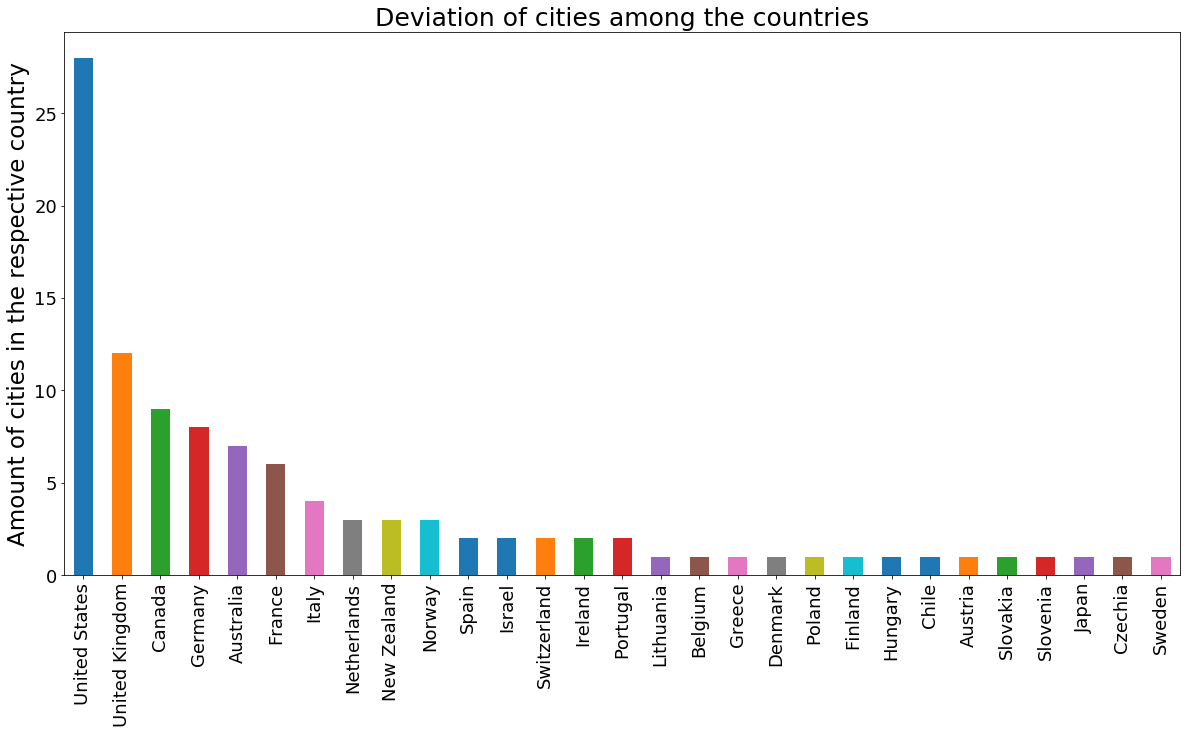

In [55]:
plt.rc('font', size=40)
df['CountryName'].value_counts().plot(kind='bar', figsize=(20,10), fontsize=18)
plt.title('Deviation of cities among the countries', fontsize=25)
plt.ylabel('Amount of cities in the respective country', fontsize=23)

In [56]:
pd.set_option('display.float_format', '{:.2f}'.format) #set format of displayed values
df['Population'].describe()

count        107.00
mean     1417389.01
std      3232204.59
min       173535.00
25%       389205.00
50%       610892.00
75%      1255059.50
max     31480498.00
Name: Population, dtype: float64

Text(0.5,1,'Density of the population')

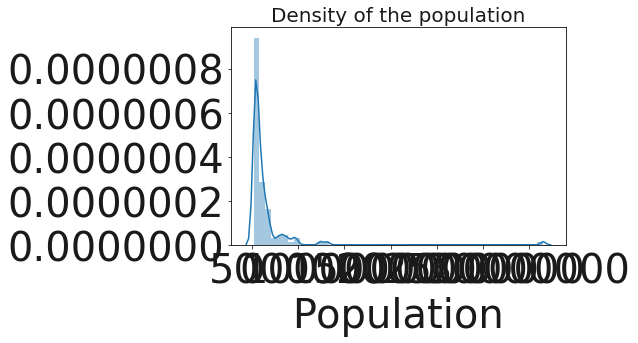

In [57]:
ax = plt.subplot()
ax.ticklabel_format(style='plain')
sns.distplot(df['Population'])
sns.set(rc={'figure.figsize':(10,7)})
plt.rcParams["axes.labelsize"] = 20
plt.title('Density of the population', fontsize=20)

In [58]:
df['Cost of Living Plus Rent Index'].describe()

count   107.00
mean     55.96
std      13.35
min      30.63
25%      48.76
50%      54.02
75%      60.06
max     101.43
Name: Cost of Living Plus Rent Index, dtype: float64

Text(0.5,1,'Density of Cost of Living Plus Rent Index')

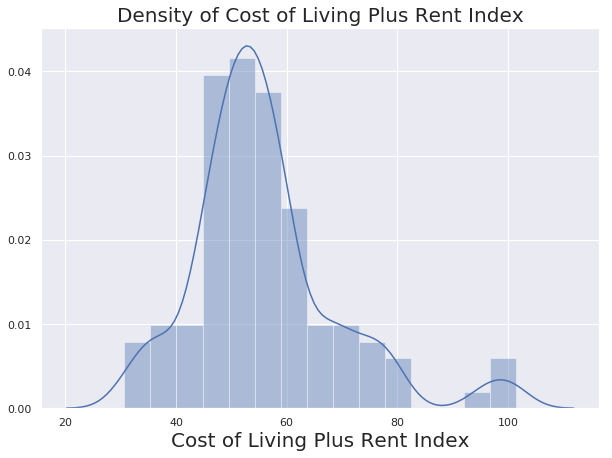

In [59]:
sns.distplot(df['Cost of Living Plus Rent Index'])
plt.title('Density of Cost of Living Plus Rent Index', fontsize=20)

In [60]:
df['Local Purchasing Power Index'].describe()

count   107.00
mean    112.04
std      24.95
min      51.83
25%      99.72
50%     112.36
75%     131.65
max     155.88
Name: Local Purchasing Power Index, dtype: float64

Text(0.5,1,'Density of Local Purchasing Power Index')

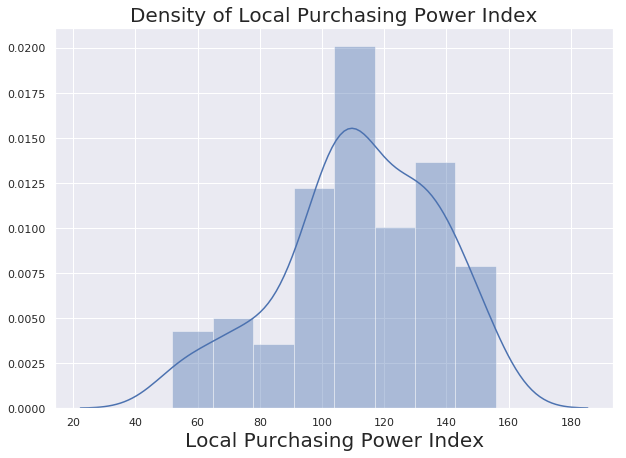

In [61]:
sns.distplot(df['Local Purchasing Power Index'])
plt.title('Density of Local Purchasing Power Index', fontsize=20)

In [62]:
df['Average Temperature'].describe()

count   107.00
mean     12.17
std       5.00
min       2.30
25%       9.06
50%      10.30
75%      15.58
max      23.92
Name: Average Temperature, dtype: float64

Text(0.5,1,'Density of Average Temperature')

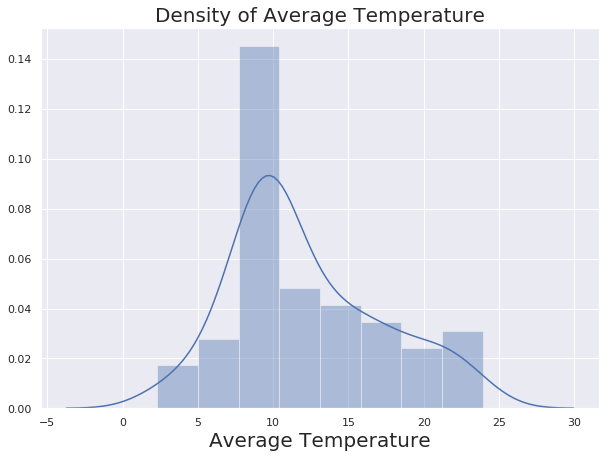

In [63]:
sns.distplot(df['Average Temperature'])
plt.title('Density of Average Temperature', fontsize=20)

In [64]:
df['Liveability'].describe()

count   107.00
mean     83.10
std       4.60
min      70.63
25%      81.28
50%      83.01
75%      84.87
max     100.00
Name: Liveability, dtype: float64

Text(0.5,1,'Density of Liveability')

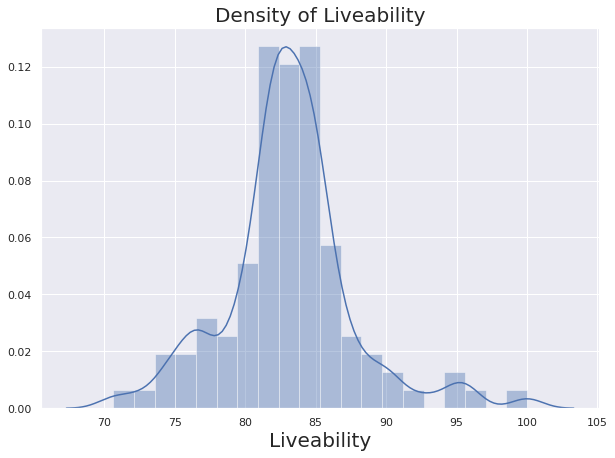

In [65]:
sns.distplot(df['Liveability'])
plt.title('Density of Liveability', fontsize=20)

In [66]:
df['Unemployment Rate'].describe()

count   107.00
mean      5.12
std       2.60
min       2.82
25%       3.47
50%       4.18
75%       6.21
max      18.07
Name: Unemployment Rate, dtype: float64

Text(0.5,1,'Density of Unemployment Rate')

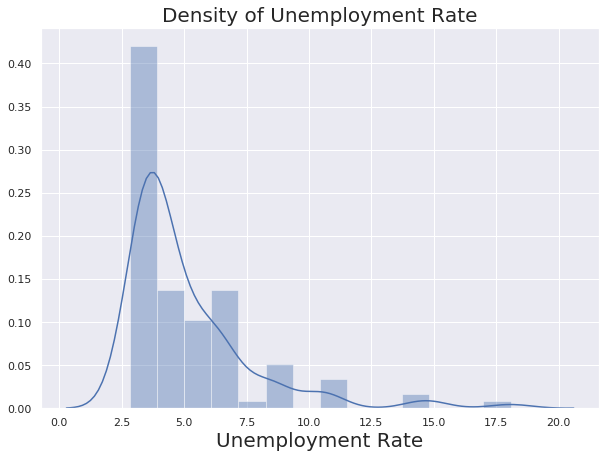

In [67]:
sns.distplot(df['Unemployment Rate'])
plt.title('Density of Unemployment Rate', fontsize=20)

In [68]:
df['Freedom'].describe()

count   107.00
mean      0.51
std       0.10
min       0.10
25%       0.51
50%       0.51
75%       0.59
max       0.64
Name: Freedom, dtype: float64

Text(0.5,1,'Density of Freedom')

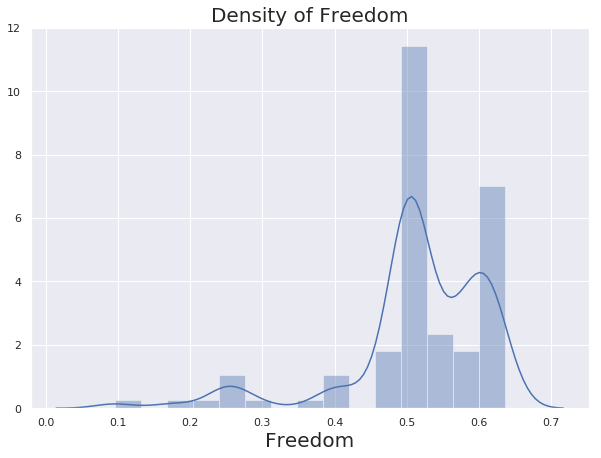

In [69]:
sns.distplot(df['Freedom'])
plt.title('Density of Freedom', fontsize=20)

In [70]:
df['Wages'].describe()

count     107.00
mean    47690.68
std     10654.89
min     21711.00
25%     42835.00
50%     48403.00
75%     60154.00
max     60154.00
Name: Wages, dtype: float64

Text(0.5,1,'Density of Wages in USD')

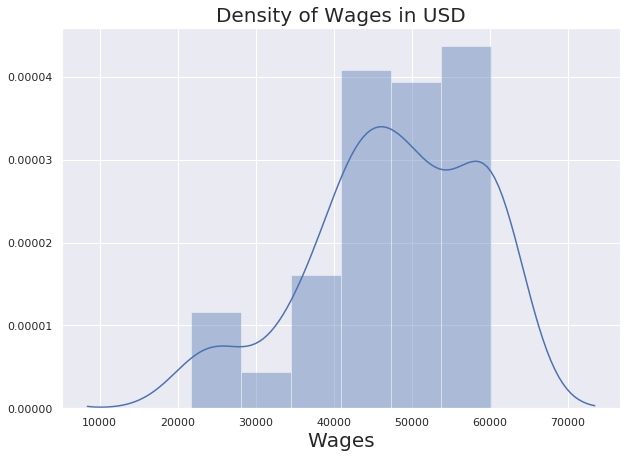

In [71]:
sns.distplot(df['Wages'])
plt.title('Density of Wages in USD', fontsize=20)

Text(0.5,0,'City')

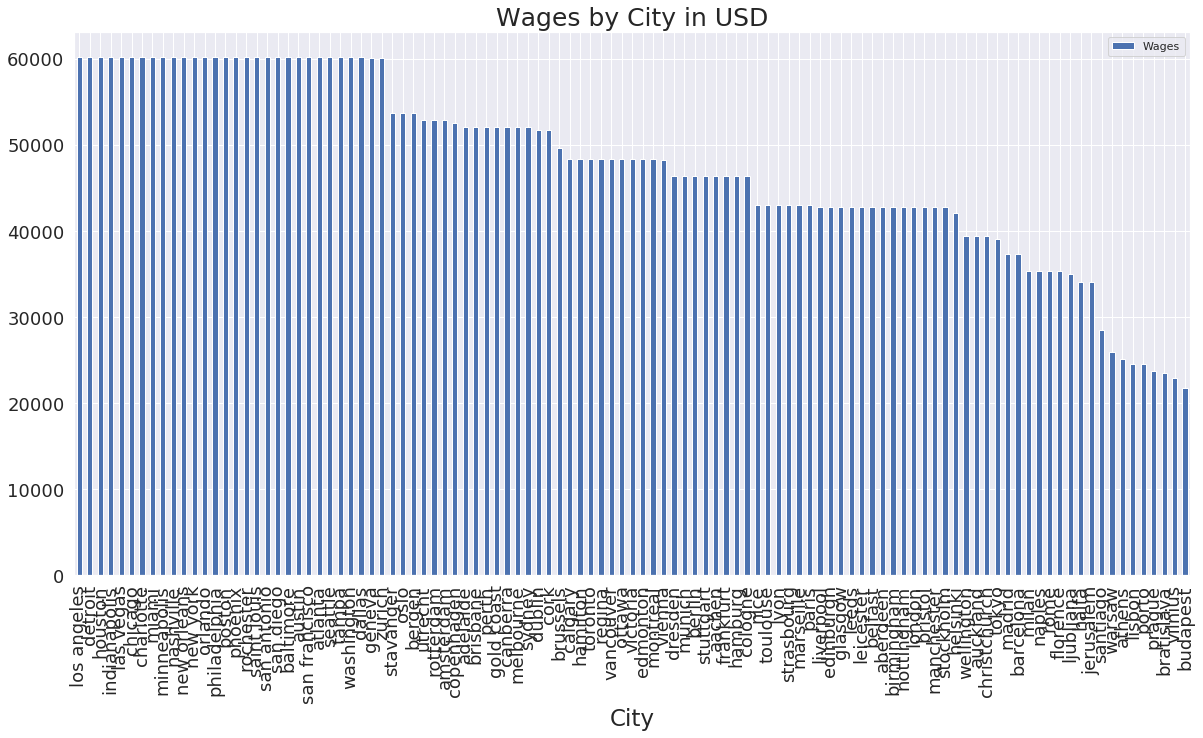

In [72]:
df[['City', 'Wages']].groupby('City').mean().sort_values('Wages', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.title('Wages by City in USD', fontsize=25)
plt.xlabel('City', fontsize=23)

Text(0.5,0,'City')

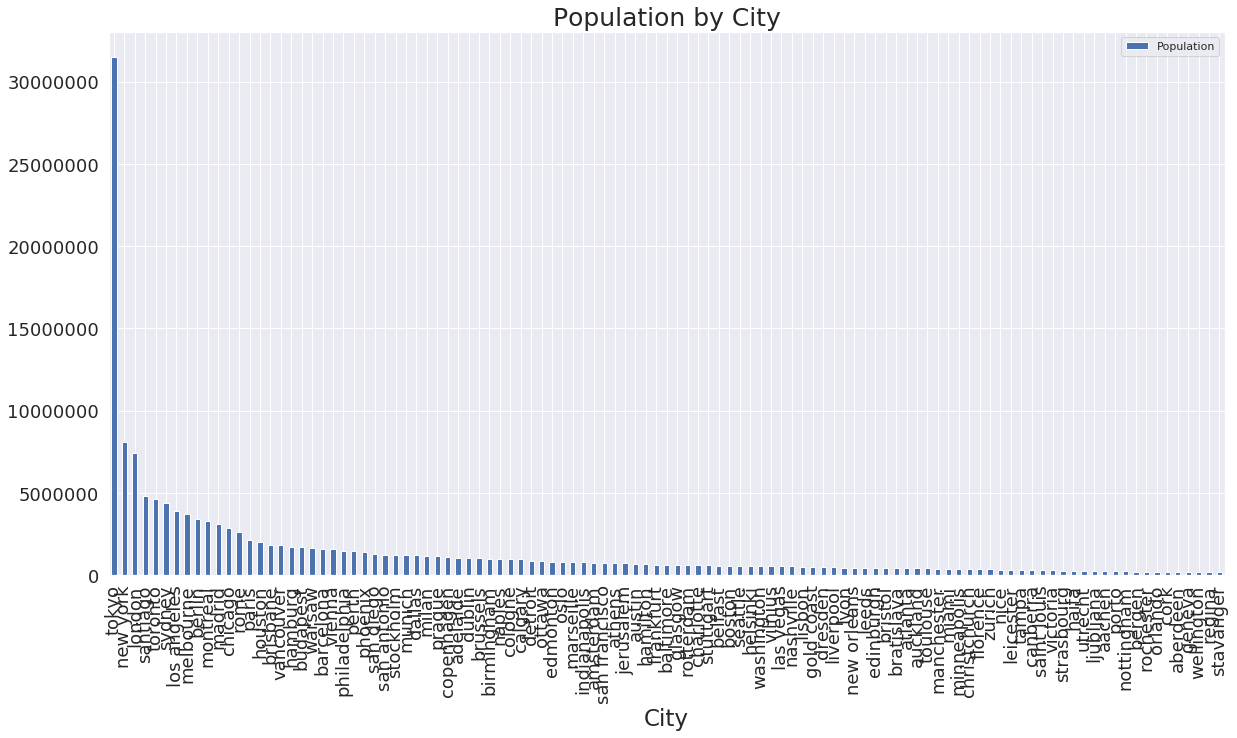

In [73]:
df[['City','Population']].groupby('City').mean().sort_values('Population', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Population by City', fontsize=25)
plt.xlabel('City', fontsize=23)

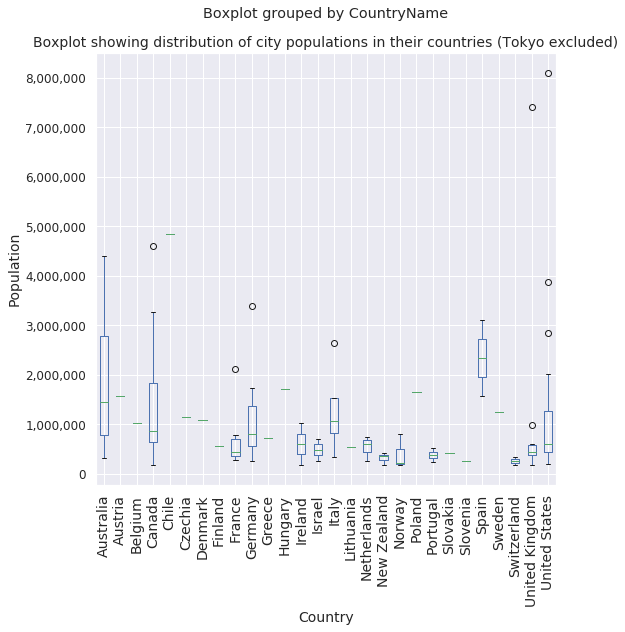

In [74]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
df_no_tokyo = df[df["City"] != "tokyo"]
#df_no_tokyo = df
ax = df_no_tokyo[['City', 'CountryName', 'Population']].boxplot(column="Population", by="CountryName", ax=ax)
ax.set_xlabel("Country", fontsize=14)
ax.set_ylabel("Population", fontsize=14)
plt.title("Boxplot showing distribution of city populations in their countries (Tokyo excluded)", fontsize=14)
plt.xticks(rotation=90, fontsize=14)

vals = ax.get_yticks()
ax.set_yticklabels(["{:,}".format(int(x)) for x in vals])
plt.yticks(fontsize=12)
plt.show()

Text(0.5,0,'Cost of Living Plus Rent Index')

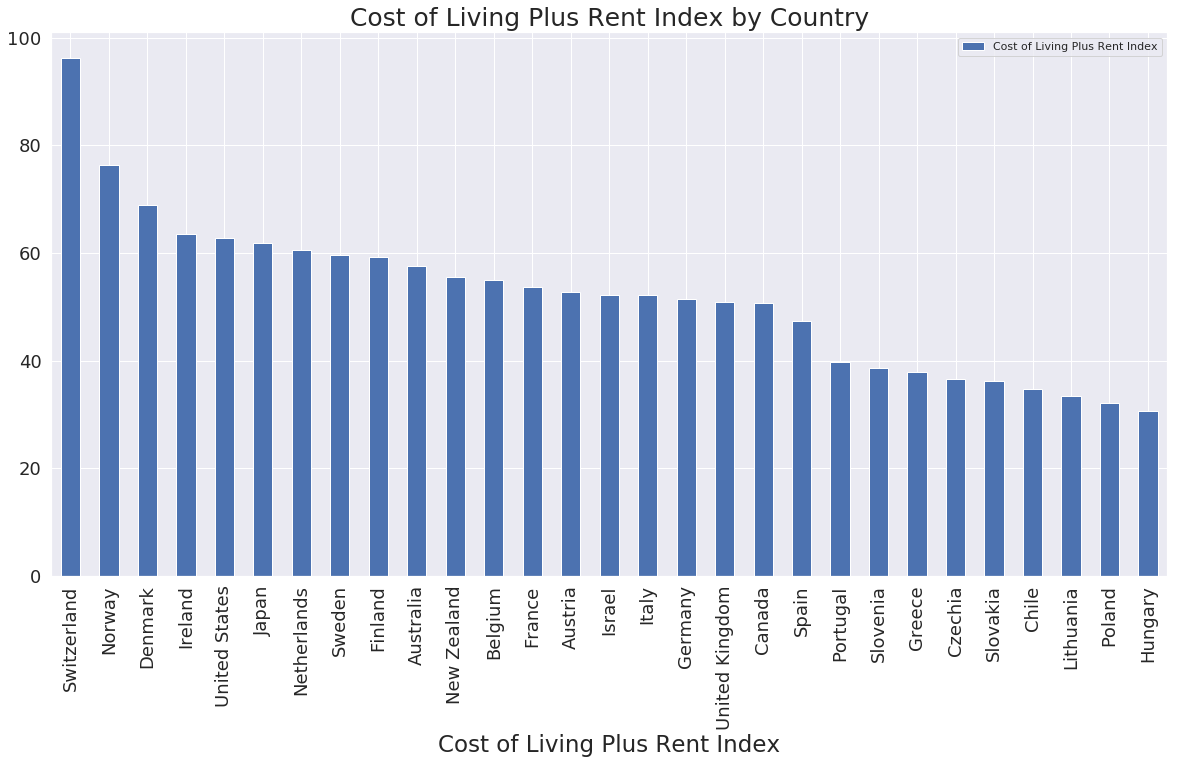

In [75]:
df[['CountryName', 'Cost of Living Plus Rent Index']].groupby('CountryName').mean().sort_values('Cost of Living Plus Rent Index', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Cost of Living Plus Rent Index by Country', fontsize=25)
plt.xlabel('Cost of Living Plus Rent Index', fontsize=23)

Text(0.5,0,'Local Purchasing Power Index')

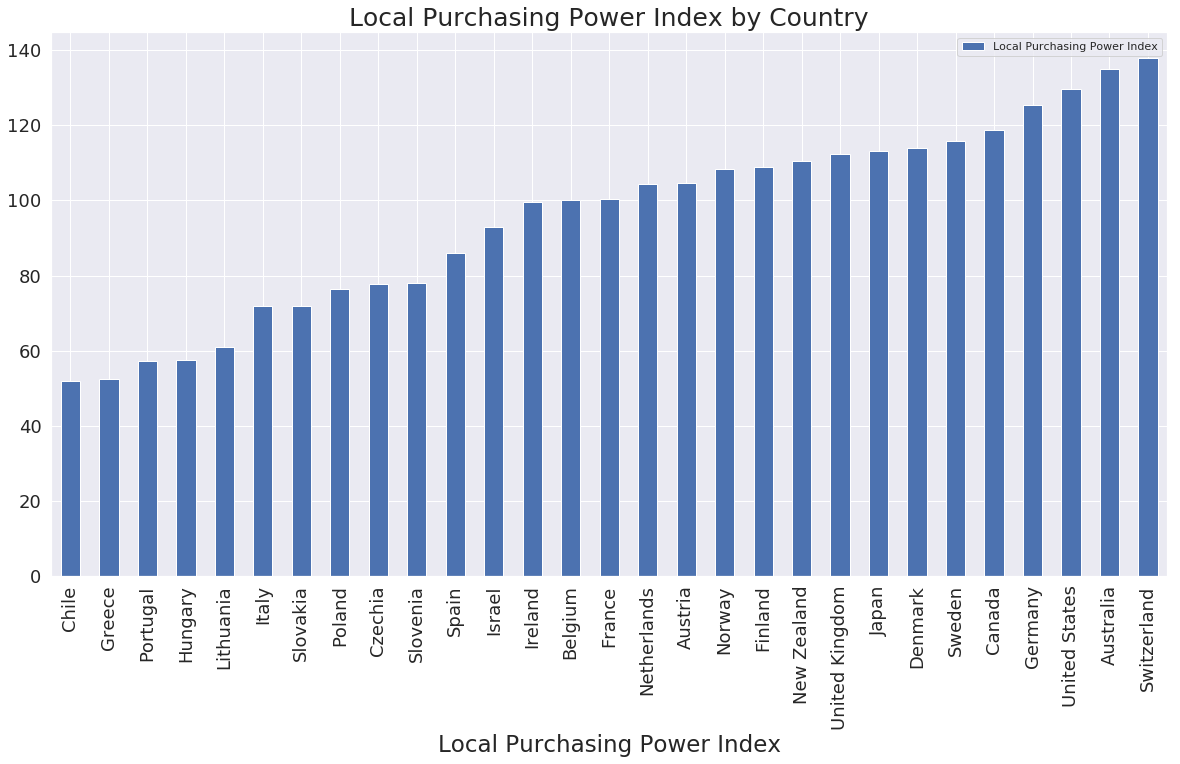

In [76]:
df[['CountryName', 'Local Purchasing Power Index']].groupby('CountryName').mean().sort_values('Local Purchasing Power Index', ascending=True).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Local Purchasing Power Index by Country', fontsize=25)
plt.xlabel('Local Purchasing Power Index', fontsize=23)

Text(0.5,0,'Average Temperature')

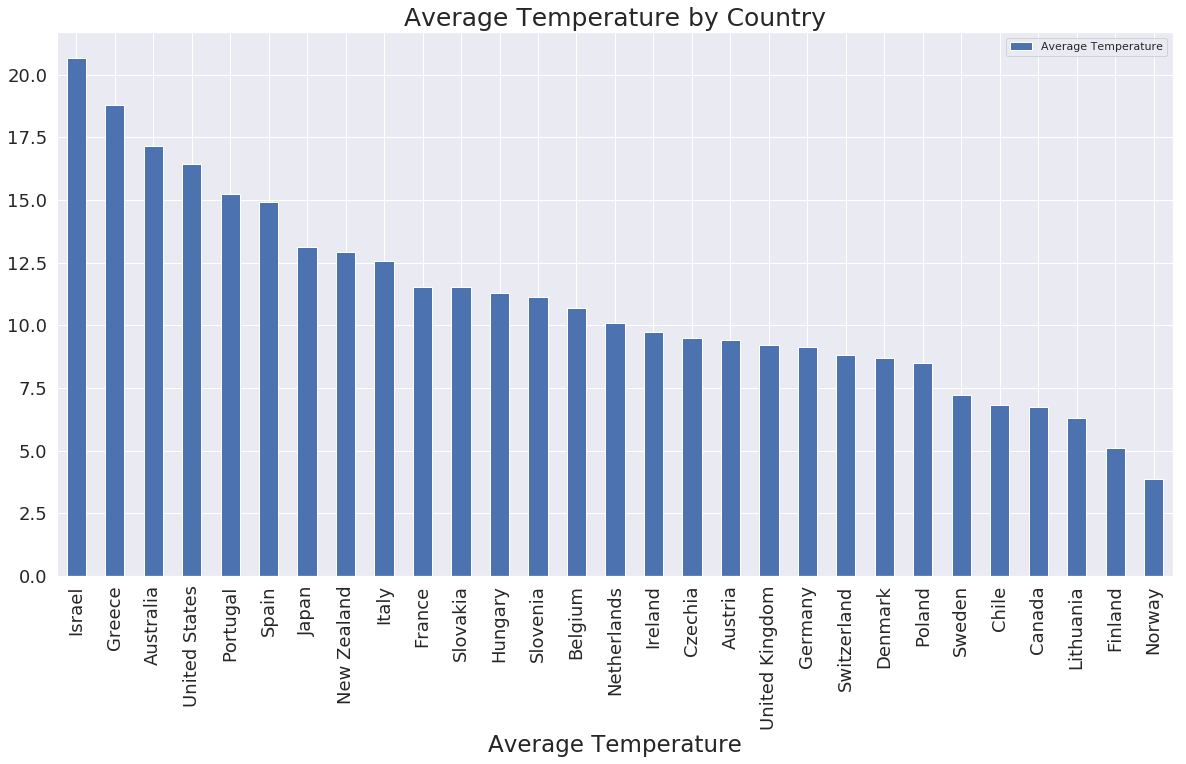

In [77]:
df[['CountryName', 'Average Temperature']].groupby('CountryName').mean().sort_values('Average Temperature', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Average Temperature by Country', fontsize=25)
plt.xlabel('Average Temperature', fontsize=23)

Text(0.5,0,'Unemployment Rate')

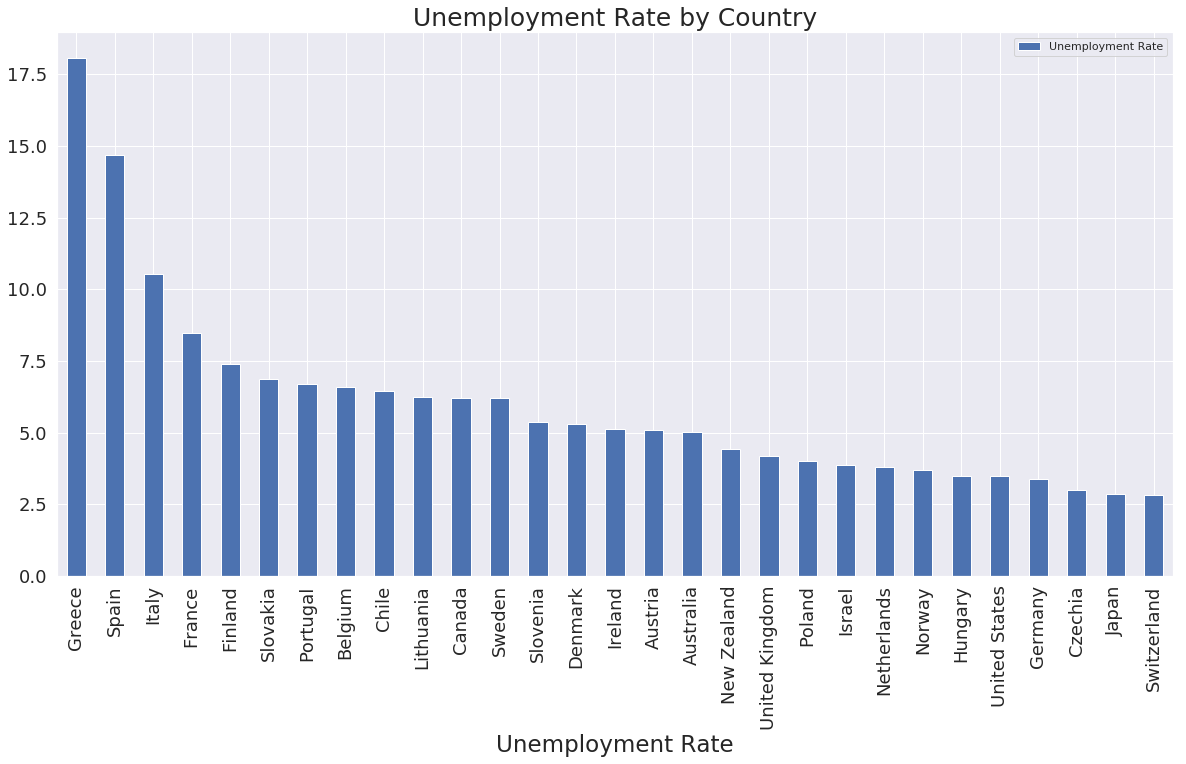

In [78]:
df[['CountryName', 'Unemployment Rate']].groupby('CountryName').mean().sort_values('Unemployment Rate', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Unemployment Rate by Country', fontsize=25)
plt.xlabel('Unemployment Rate', fontsize=23)

Text(0.5,0,'Freedom')

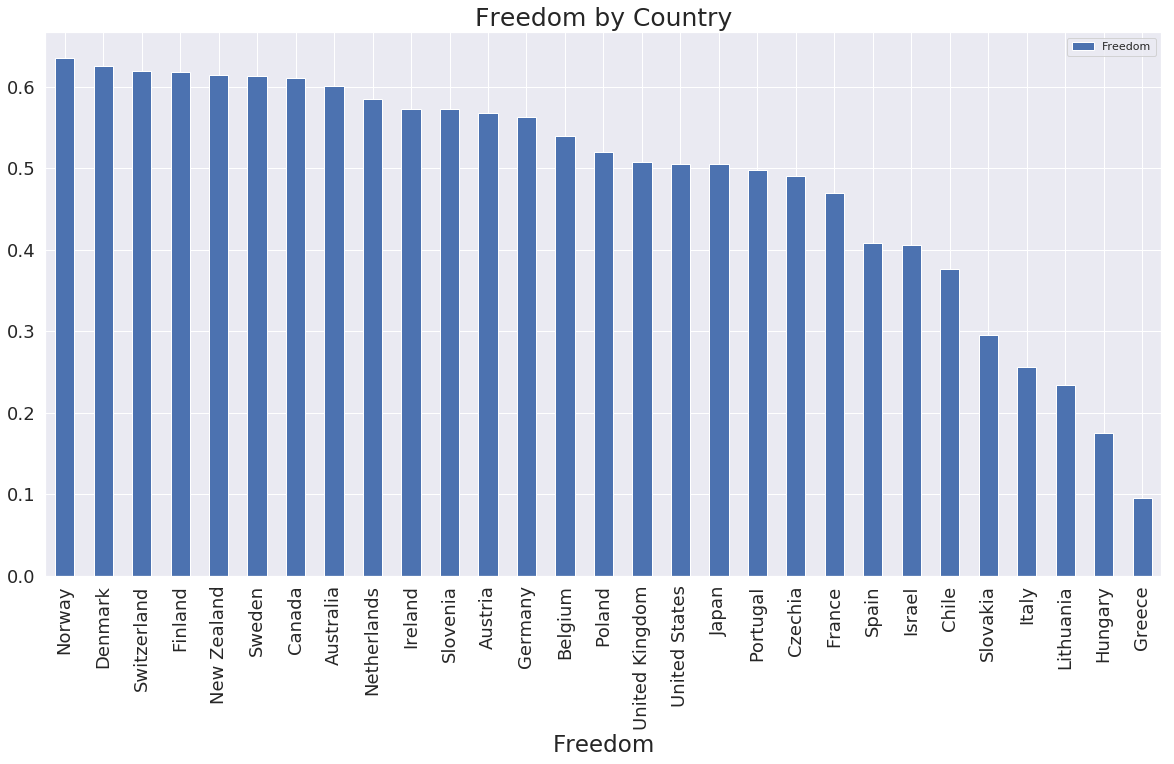

In [79]:
df[['CountryName', 'Freedom']].groupby('CountryName').mean().sort_values('Freedom', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Freedom by Country', fontsize=25)
plt.xlabel('Freedom', fontsize=23)

Text(0.5,0,'Wages')

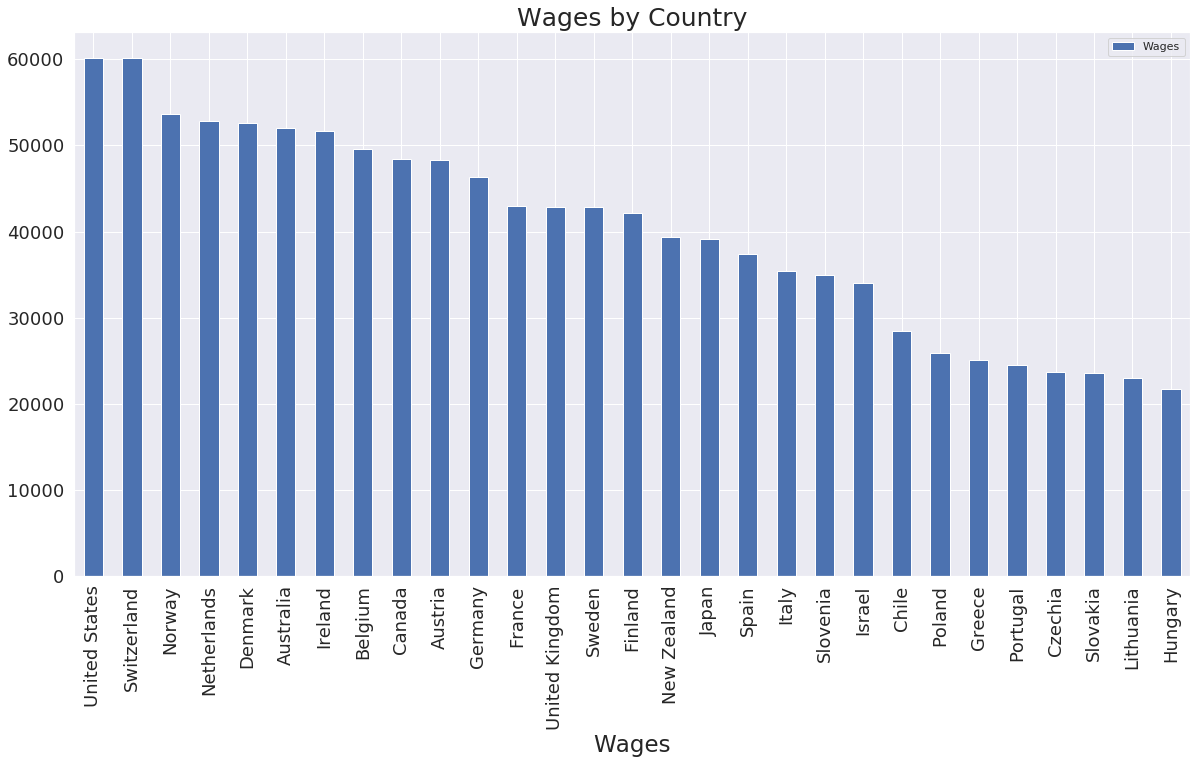

In [80]:
df[['CountryName', 'Wages']].groupby('CountryName').mean().sort_values('Wages', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Wages by Country', fontsize=25)
plt.xlabel('Wages', fontsize=23)

Text(0.5,0,'Liveability')

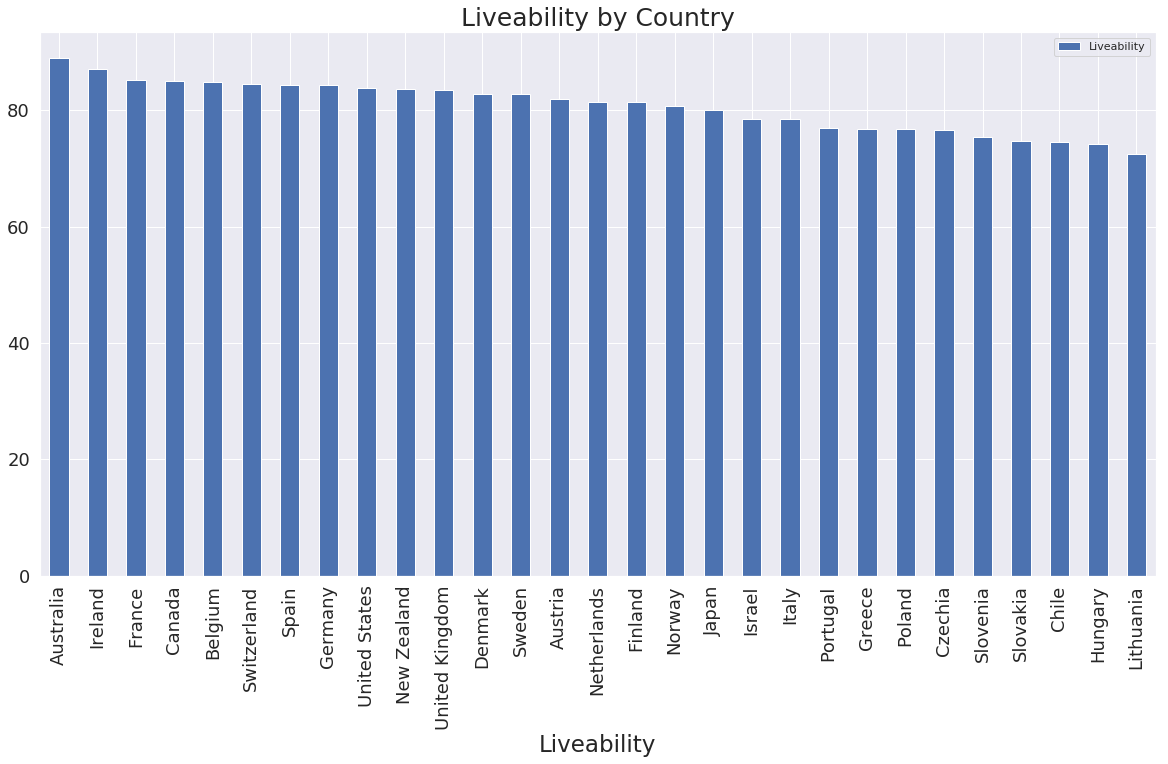

In [81]:
df[['CountryName', 'Liveability']].groupby('CountryName').mean().sort_values('Liveability', ascending=False).plot(kind='bar', figsize=(20,10), fontsize=18)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Liveability by Country', fontsize=25)
plt.xlabel('Liveability', fontsize=23)

<h2>Distance matrix</h2>

In [82]:
df.head()

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Average Temperature,Liveability,Unemployment Rate,Freedom,Wages,CountryName
0,tokyo,JP,31480498.00,35.69,139.75,61.89,113.09,13.11,80.00,2.87,0.51,39113,Japan
1,new york,US,8107916.00,40.71,-74.01,100.00,100.00,11.97,90.53,3.47,0.51,60154,United States
2,los angeles,US,3877129.00,34.05,-118.24,74.25,114.51,17.09,86.86,3.47,0.51,60154,United States
3,chicago,US,2841952.00,41.85,-87.65,67.01,133.70,12.82,83.01,3.47,0.51,60154,United States
4,houston,US,2027712.00,29.76,-95.36,53.14,155.88,21.86,85.24,3.47,0.51,60154,United States


In [83]:
# Normalize columns.
cities_indices = df["City"]
normalised_data = df.copy()
normalised_data.drop(["City", "Country", "CountryName"], axis=1, inplace=True)
def scaled_value(value, column):
    return ((value - normalised_data[column].min()) /
            (normalised_data[column].max() - normalised_data[column].min()))
for col in normalised_data:
    if col not in ["City", "Country", "CountryName"]:
        normalised_data[col] = normalised_data.apply(lambda row: scaled_value(row[col], col), axis = 1)

In [84]:
normalised_data.describe()

,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Average Temperature,Liveability,Unemployment Rate,Freedom,Wages
count,107.00,107.00,107.00,107.00,107.00,107.00,107.00,107.00,107.00,107.00
mean,0.04,0.78,0.37,0.36,0.58,0.46,0.42,0.15,0.78,0.68
std,0.10,0.25,0.25,0.19,0.24,0.23,0.16,0.17,0.19,0.28
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.01,0.76,0.15,0.26,0.46,0.31,0.36,0.04,0.76,0.55
50%,0.01,0.85,0.41,0.33,0.58,0.37,0.42,0.09,0.76,0.69
75%,0.03,0.91,0.46,0.42,0.77,0.61,0.48,0.22,0.92,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [85]:
def distanceFce(indA, indB):
    rowA = normalised_data.iloc[indA]
    rowB = normalised_data.iloc[indB]
    # TODO #################################################
    result = np.mean(np.abs(rowA.values - rowB.values))
    ########################################################
    return result

In [86]:
indices = normalised_data.index.values
v = np.vectorize(distanceFce)
# Magic:
matrix = v(indices[:, np.newaxis], indices)

In [87]:
matrix.shape

(107, 107)

<h2>Clustering (just messing around now, nothing finalised yet)</h2>

In [88]:
def plot_cities(lons, lats, labels, figsize=(10,10), cities=None):
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())
    #ax = plt.axes(projection=ccrs.EuroPP())
    ax.stock_img()
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    colors = ["red", "green", "blue", "yellow", "purple", "black", "orange", "brown"]
    cs = [colors[l] for l in labels]
    ret = plt.scatter(lons, lats,
                color=cs, marker='o',
                transform=ccrs.Geodetic()
               )
    plt.show()

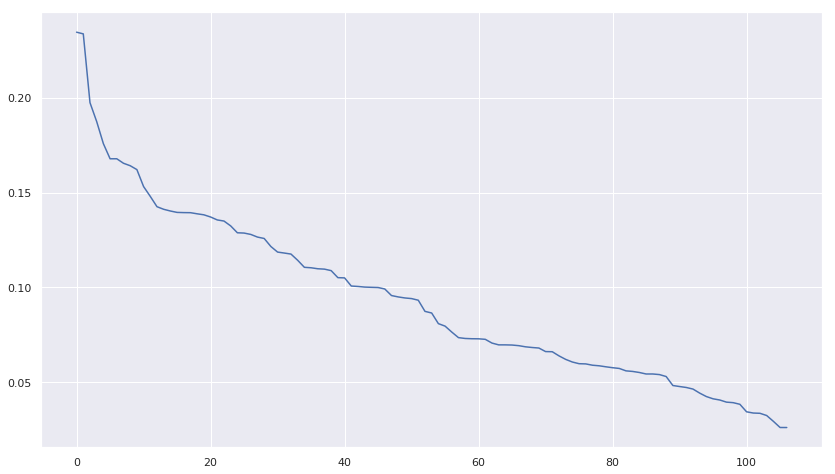

In [120]:
# Decide eps for DBSCAN using k-distance graph.
min_samples = 8
nbrs = NearestNeighbors(metric="precomputed").fit(matrix)
distances, indices = nbrs.kneighbors(n_neighbors=min_samples)
kdist = distances[:, -1]
kdist.sort()
kdist = kdist[::-1]
plt.figure(figsize=(14,8))
plt.plot(range(len(kdist)), kdist)
plt.show()

In [130]:
eps = 0.1
model = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed")
labels_1 = model.fit(matrix).labels_
labels_1 -= np.min(labels_1)
np.unique(labels_1)

array([0, 1, 2, 3])

In [131]:
df.head(5)

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Average Temperature,Liveability,Unemployment Rate,Freedom,Wages,CountryName
0,tokyo,JP,31480498.00,35.69,139.75,61.89,113.09,13.11,80.00,2.87,0.51,39113,Japan
1,new york,US,8107916.00,40.71,-74.01,100.00,100.00,11.97,90.53,3.47,0.51,60154,United States
2,los angeles,US,3877129.00,34.05,-118.24,74.25,114.51,17.09,86.86,3.47,0.51,60154,United States
3,chicago,US,2841952.00,41.85,-87.65,67.01,133.70,12.82,83.01,3.47,0.51,60154,United States
4,houston,US,2027712.00,29.76,-95.36,53.14,155.88,21.86,85.24,3.47,0.51,60154,United States


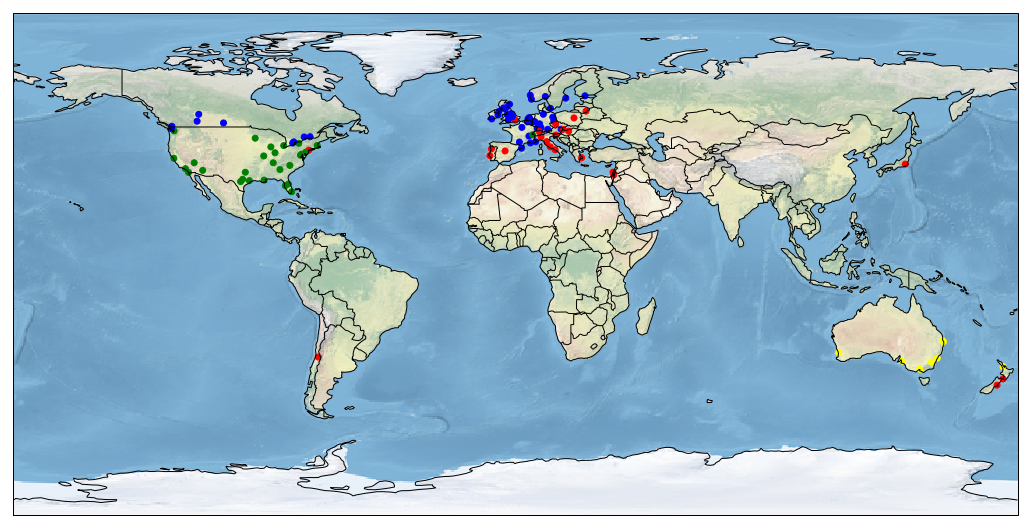

In [132]:
#plot_df = df[(df["Longitude"] > -10) & (df["Longitude"] < 30) & (df["Latitude"] > 35 ) & (df["Latitude"] < 60)]
plot_df = df
plot_cities(plot_df['Longitude'], plot_df['Latitude'], labels=labels_1, figsize=(18, 12), cities=plot_df.City.values)

In [109]:
df[df.City.isin(["munich", "prague", "melbourne", "berlin", "amsterdam", "copenhagen", "hamburg", "zurich"])]

,City,Country,Population,Latitude,Longitude,Cost of Living Plus Rent Index,Local Purchasing Power Index,Average Temperature,Liveability,Unemployment Rate,Freedom,Wages,CountryName
52,melbourne,AU,3730212.00,-37.81,144.96,59.48,131.85,14.27,92.58,5.02,0.60,52063,Australia
58,berlin,DE,3398362.00,52.52,13.40,50.65,112.36,9.96,89.54,3.39,0.56,46389,Germany
59,hamburg,DE,1733846.00,53.55,10.00,54.68,113.28,9.20,84.66,3.39,0.56,46389,Germany
60,munich,DE,1246133.00,48.15,11.58,60.25,114.57,5.88,86.00,3.39,0.56,46389,Germany
82,prague,CZ,1154508.00,50.08,14.47,36.59,77.71,9.51,76.64,3.00,0.49,23722,Czechia
83,copenhagen,DK,1089958.00,55.67,12.58,68.94,114.05,8.70,82.85,5.30,0.63,52580,Denmark
90,amsterdam,NL,745811.00,52.35,4.92,69.13,98.88,10.08,84.00,3.80,0.59,52833,Netherlands
104,zurich,CH,346185.00,47.37,8.55,97.39,142.39,7.96,85.89,2.82,0.62,60124,Switzerland


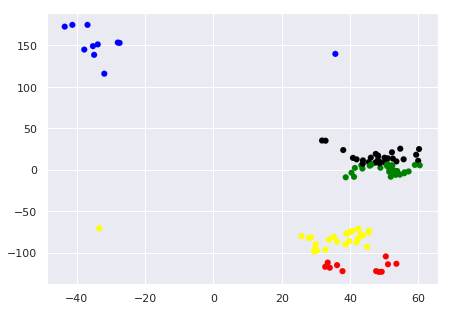

In [92]:
K_df = 5
km_1 = KMeans(n_clusters=K_df, init="random")
labels_1 = km_1.fit(df[['Latitude','Longitude']]).labels_
colors = ["red", "blue", "green", "yellow", "black", "purple"]
labels_1 = [colors[l] for l in labels_1]
plt.figure(figsize=(7,5))
plt.scatter(df['Latitude'], df['Longitude'], c = labels_1, alpha = 1.0, lw = 0.1)

<h2>Calculation of City Quality</h2>

The general approach is to take the maximum and minimum values of the column and use these to build a range where the max value earns 100% of the score and the min value earns 0%. We can discuss that though since the max value doesn’t necessarily mean its "perfect" and the min value doesn’t mean that it definitely "sucks" but for now I used that approach.

Example Cost of Living Plus Rent Index:
min     30.63
max     97.39
Apply scaling: -> 97.39 is perfect (100%), 30.63 sucks (0%)
E.g. Melbourne: has 59.48 as Cost of Living Plus Rent Index -> 59.48 - 30.63 / 97.39 - 30.63 = 0.43 -> Melbourne earns 43% in that category.

So the general formula is: (value of City - minValue) / (maxValue - minValue)

Then there are special cases: Population, Average Temperature, Unemployment Rate

Population

For population I assumed a population between 1 and 5 million is perfect (again debatable) so that scores 100% again. If it’s below that range, I calculate the difference. Since the highest possible difference is 1,000,000, I use that as a scale again. For values above the 1 to 5 million range I assumed the highest possible difference is 29,000,000 since Shanghai has the highest population of 34,000,000 so that’s the highest possible difference. I use this value as a scale then again.

So if population p is 1,000,000 < p < 5,000,000 -> perfect (100%)
if its below: calculate difference: e.g. 1,000,000 - 752,000 = 248,000
differences range from 0 to 1,000,000 so use scaling: 248,000/1,000,000 = 24,8% -> 1 - 0.248 -> total value is 0.752
if it’s above: calculate difference: e.g. 5,000,000 - 12,000,000 = -7,000,000 = 7,000,000 
differences range from 0 to 30,000,000, so use scaling: 7,000,000/29,000,000 = 0.24 -> 1 - 0.24 -> total value is 0.76

1,000,000 - value / 1,000,000
5,000,000 - value / 29,000,000

Average Temperature

Here I took the max and min values again.
min      2.30
max     22.20
I assumed values between 50% and 80% in that range are optimal (debatable).
100%: 22.2 - 2.3 = 19.9
50%: 9.95
80%: 15.92
So every value between 9.95 and 15.92 receives 100%. For values above and below the range, the same procedure than for population applies.

Unemployment Rate

The lower the unemployment rate the better so its the same procedure with different signs.
min      2.82
max     18.07
-> 2.82 receives 100%.
E.g. Melbourne: Unemployment Rate is 5.02 -> 5.02 / 18.07 = 0.28 -> take 1 - 0.28 = 0.72 -> Total value is 0.72

Final Formula

For the final formula each of the categories can score up to 100% and afterwards we can give them a weight, e.g. the Livability score is 3 times more important than the Population score. For now the final formula looks like this (contains some halfway pseudo code):

City Quality =

#Population
if(dfcity['Population'] < 1,000,000):
    achieved_score = 1 - ((1,000,000 - dfcity['Population']) / 1,000,000)
elseif(dfcity['Population'] > 5,000,000):
    achieved_score = 1 - (abs(5,000,000 - dfcity['Population']) / 29,000,000)
elseif(dfcity['Population'] > 1,000,000 AND dfcity['Population'] < 5,000,000
    achieved_score = 1.0
+ 
(dfcity['Cost of Living Plus Rent Index'] - dfmin['Cost of Living Plus Rent Index']) / (dfmax['Cost of Living Plus Rent Index'] - dfmin['Cost of Living Plus Rent Index']) 
+ 
(dfcity['Local Purchasing Power Index'] - dfmin['Local Purchasing Power Index']) / (dfmax['Local Purchasing Power Index'] - dfmin['Local Purchasing Power Index']) 
+ 
#Average Temperature 
if(dfcity['Average Temperature'] < 9.95):
    achieved_score = 1 - (9.95 - dfcity['Average Temperature']) / 9.95
elseif(dfcity['Average Temperature'] > 15.92):
    achieved_score = 1 - (abs(15.92 - dfcity['Average Temperature']) / 15.92)
elseif(dfcity['Average Temperature'] > 9.95 AND dfcity['Average Temperature'] < 15.92
    achieved_score = 1.0
+ 
(dfcity['Liveability'] - dfmin['Liveability']) / (dfmax['Liveability'] - dfmin['Liveability']) 
+ 
(1 - (dfcity['Unemployment Rate'] - dfmin['Unemployment Rate']) / (dfmax['Unemployment Rate'] - dfmin['Unemployment Rate'])) 
+ 
(dfcity['Freedom'] - dfmin['Freedom']) / (dfmax['Freedom'] - dfmin['Freedom']) 
+ 
(dfcity['Wages'] - dfmin['Wages']) / (dfmax['Wages'] - dfmin['Wages'])


In [ ]:
# Function to calculate population score
def calulcatePopulationScore(x):
    if(x < 1000000):
        return (1 - ((1000000 - x) / 1000000))
    elif(x > 5000000):
        return (1 - (abs(5000000 - x) / 29000000))
    elif(x > 1000000 and x < 5000000):
        return(float(1))

# Function to calculate temperature score
def calulcateTemperatureScore(x):
    if(x < 9.95):
        return(1 - (9.95 - x) / 9.95)
    elif(x > 15.92):
        return(1 - (abs(15.92 - x) / 15.92))
    elif(x > 9.95 and x < 15.92):
        return(float(1))
    
# Calculate the final City Quality. 8 is the highest possible value at the moment. 
# The criterias arent weigthed yet though. 
# Couldn't do this in multiple lines, Python said no. I know it's hard to read and not clear...
df['City Quality'] = df.apply(lambda row: calulcatePopulationScore(row['Population']) + (row['Cost of Living Plus Rent Index'] - 30.63) / (97.39 - 30.63) + (row['Local Purchasing Power Index'] - 51.83) / (153.77 - 51.83) + calulcateTemperatureScore(row['Average Temperature']) + (row['Liveability'] - 72.45) / (100.00 - 72.45) + (1 - (row['Unemployment Rate'] - 2.82) / (18.07 - 2.82)) + (row['Freedom'] - 0.10) / (0.64 - 0.10) + (row['Wages'] - 21711.00) / (60124.00 - 21711.00), axis = 1)

In [ ]:
# Final ranking, Sydney is the winner right now. And Australian cities perform quite well.
df[['City', 'City Quality']].sort_values(by='City Quality', ascending=False)